Analyzing Media Coverage Of Other Countries in Austria
===


The aim of this project is to find out how reporting in Austria's print media about certain countries has changed over time (sentiment, which topics). In two further steps, I would also like to go down to the level of the individual newspapers and their authors and take an explorative look at whether there are tendencies/bias here. As countries of interest I choose Balkan countries because of their proximity to Austria and their long history of conflict.

    Text corpora: Austrian newspaper articles (or their respective twitter posts)
    Language: German
    Time: 2000–2022
    Method: Adding country labels to the articles, Sentiment Scores (, extracting underlying topics of the articles, e.g. with fuzzy topic modeling) 
    
According to https://de.wikipedia.org/wiki/Liste_%C3%B6sterreichischer_Zeitungen_und_Zeitschriften derstandard.at and krone.at reach the most people online, they also cover Austrian society quite well. So, initially, I will focus on these two and might add some more newspapers at a later stage.

* Focus on 2 countries: Serbia and Croatia (like Austria now a EU country)
* I will label an article with "Serbia" if the ratio of amount of words that relate to "Serbia"  compared to words that relate to "Croatia" is greater than 4
* I will also try to find out if there are certain authors who are responsible for a certain tendency.
* Another analysis could be build upon the ratio of "Serbia" and "Albania" or "Kosovo"

**Hypothesis 1: Tweets about Croatia are on average more positive than tweets about Serbia**

In [1]:
import jupyter_black

jupyter_black.load()

In [178]:
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data_dir = "data/twitter"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def dl_user(user, max_results=None, local=False):
    """
    Function to download tweets by username.
    Set local to True, if tweets have already
    been downloaded and are available in data_dir.

    Returns a DataFrame.

    """

    if local == False:
        with open(data_dir + f"/user-{user}.json", "w+") as fo:
            if max_results == None:
                cmd_list = ["snscrape", "--jsonl", "twitter-user", user]
            else:
                cmd_list = [
                    "snscrape",
                    "--jsonl",
                    "-n " + str(max_results),
                    "twitter-user",
                    user,
                ]
            p = subprocess.Popen(cmd_list, stdout=fo)
            p.wait()

    with open(data_dir + f"/user-{user}.json", "r") as fo:
        tweets = fo.readlines()

    tweets = [json.loads(tweets[i]) for i in range(0, len(tweets))]
    print("loaded", len(tweets), "tweets\n")

    df_tweets = pd.DataFrame(tweets)
    df_tweets["date"] = pd.to_datetime(df_tweets["date"])

    return df_tweets

# 1. Scraping newspaper articles

## 1.1. derStandard.at


In [53]:
df_tweets = dl_user("derstandardat", max_results=None, local=True)


df_tweets[["date", "rawContent", "hashtags"]].head()

loaded 272281 tweets



,date,rawContent,hashtags
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...,None
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de...",None
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze...",None
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve...",None
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...,None


### Compute sentiment scores for all tweets

In [308]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


df_tweets["sentiment_textblob"] = df_tweets.renderedContent.apply(
    lambda x: TextBlob(x).polarity
)
df_tweets["sentiment_vader"] = df_tweets.renderedContent.apply(
    lambda x: sid.polarity_scores(x)["compound"]
)

### Which hashtags are most often used by this user

In [309]:
len_nohashtags = sum(pd.isna(df_tweets.hashtags))
len_nohashtags

260302

In [310]:
hashtags = list(df_tweets.hashtags.dropna())

In [311]:
len(hashtags)

11979

In [312]:
hashtags[623]

['Bundespressedienst']

In [313]:
hashtags_flat = [item for sublist in hashtags for item in sublist]

len(hashtags_flat)

15147

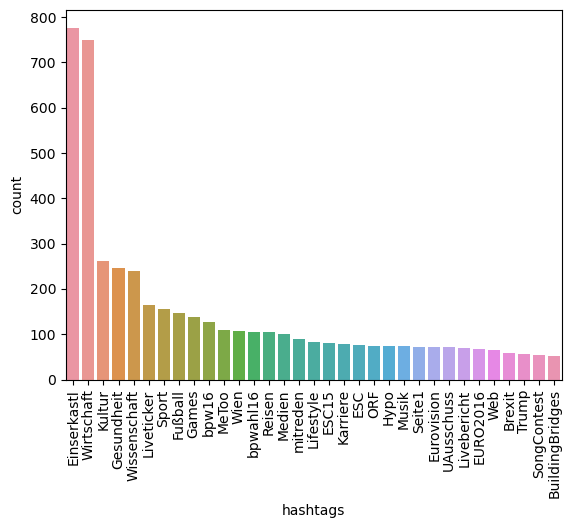

In [314]:
df_hashtags = pd.concat(
    [
        pd.DataFrame(hashtags_flat, columns=["hashtags"]),
        df_tweets.loc[pd.isna(df_tweets.hashtags), ["hashtags"]],
    ],
    sort=False,
).astype(str)

df_hashtags["count"] = 1
df_hashtags = (
    df_hashtags.groupby(["hashtags"])
    .count()
    .sort_values("count", ascending=False)
    .reset_index()
)

# all the ones tha occur only few times and label them as "other" and group again
df_hashtags.loc[df_hashtags["count"] <= 50, "hashtags"] = "other"
df_hashtags = (
    df_hashtags.groupby(["hashtags"])
    .sum()
    .sort_values("count", ascending=False)
    .reset_index()
)

# drop the first 2 most frequently hashtags (None, other)
sns.barplot(x="hashtags", y="count", data=df_hashtags.drop(0, axis=0).drop(1, axis=0))
plt.xticks(rotation=90);

### Which countries are the tweets referring to (Serbia, Croatia)?

In [456]:
countries = dict(
    serbia=["serbien", "serbe", "serbin", "serbisch", "serbo"],
    croatia=["kroatien", "kroate", "kroatin", "kroatisch", "kroato"],
    romania=["rumänien", "rumäne", "rumänin", "rumänisch"],
    hungary=["ungarn", "ungar", "ungarin", "ungarisch", "ungaro"],
    finland=["finnland", "finne", "finnin", "finnisch", "finno"],
    norway=["norwegen", "norweger", "norwegisch"],
    sweden=["schweden", "schwedin", "schwedisch"],
    danmark=["dänisch", "dänen", "dänin", "dänisch"],
    poland=["polen", "pole", "polin", "polnisch"],
    bulgaria=["bulgarien", "bulgare", "bulgarin", "bulgarisch"],
    russia=["russland", "russe", "russin", "russen", "russisch"],
    ukraine=["ukraine", "ukrainisch"],
    germany=["deutschland", "deutsche"],
    frankreich=["frankreich", "franzose", "französi"],
    slovenia=["slowenien", "slowene", "sloweni"],
    italy=["italien"],
    spain=["spanien", "spanier", "spanisch"],
    portugal=["portual", "portugiese", "portugiesin", "portugiesisch"],
    switzerland=["schweiz"],
    austria=["österreich"],
    slovakia=["slowakei", "slowake", "slowakin", "slowakisch"],
    czechia=["tschechien", "tscheche", "tschechin", "tschechisch"],
    belarus=[
        "belarus",
        "weißrussland",
        "weissrussland",
        "weißrussisch",
        "weissrussisch",
        "weißrusse",
        "weissrusse",
        "weißrussin",
        "weissrussin",
    ],
    bosnia=["bosnien", "bosnisch", "herzegowina", "bosnier", "herzegowinisch"],
    montenegro=["montenegro", "montenegriner", "montenegrinisch"],
    albania=["albanien", "albaner", "albanisch"],
)

#### Function for finding tweets about countries

In [457]:
def get_country(df_tweets, country, not_country=None, and_country=None):
    """

    Filters DataFrame with tweets to country-
    specific tweets.

    Optional: Can exclude tweeds of specific other countries
    via not_country variable.

    """

    df_country = df_tweets[
        ["date", "renderedContent", "sentiment_vader", "sentiment_textblob"]
    ].copy()

    if not_country != None:

        df_country = df_country.loc[
            df_country.renderedContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
            & ~df_country.renderedContent.str.lower().str.contains(
                "|".join(not_country), regex=True
            )
        ].reset_index(drop=True)

    else:
        df_country = df_country.loc[
            df_country.renderedContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
        ].reset_index(drop=True)

    return df_country

### Compare sentiments betweens countries

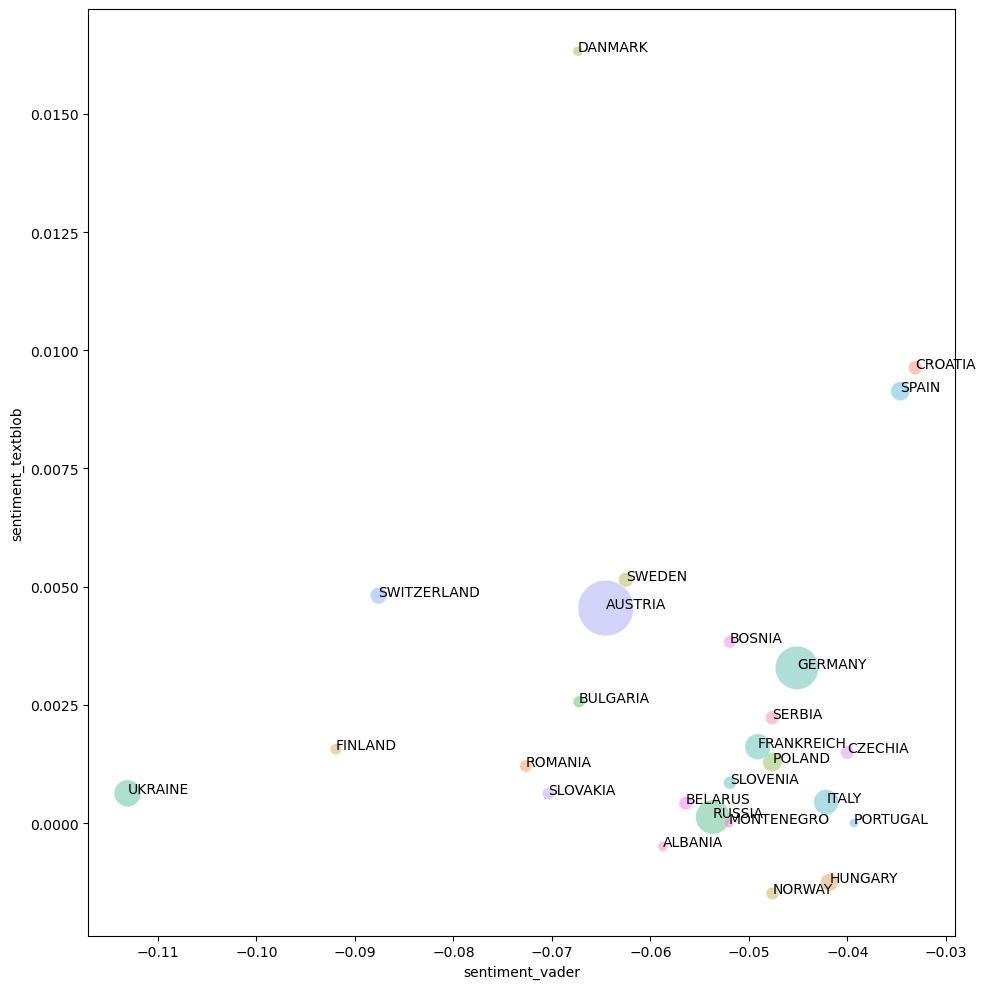

In [463]:
df_scores = pd.DataFrame()

for key in countries.keys():
    df_scores_tmp = get_country(df_tweets, countries[key])[
        ["sentiment_vader", "sentiment_textblob"]
    ]
    count = len(df_scores_tmp)
    df_scores_tmp = pd.DataFrame(
        df_scores_tmp.mean(),
        columns=[key],
    ).T
    df_scores_tmp["count"] = count
    df_scores = pd.concat([df_scores, df_scores_tmp], sort=False)

df_scores = df_scores.reset_index().rename(columns={"index": "country"})

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_scores,
    x="sentiment_vader",
    y="sentiment_textblob",
    hue="country",
    size="count",
    sizes=(40, 1600),
    legend=False,
    alpha=0.4,
)

for tup in df_scores.itertuples():
    plt.annotate(tup[1].upper(), (tup[2], tup[3]))

plt.tight_layout()

#### Find tweets about Serbia (but not Croatia)

In [458]:
df_serbien = get_country(df_tweets, serbia, croatia)


df_serbien.head()

,date,renderedContent,sentiment_vader,sentiment_textblob
0,2023-01-23 21:45:59+00:00,"Serbiens Präsident Vučić in Kosovo-Frage für ""...",0.0,0.0
1,2023-01-07 16:13:24+00:00,"Spannungen im Nordkosovo: ""Serbien muss nun vo...",0.0,0.0
2,2023-01-06 20:24:57+00:00,Soldat im Kosovo verwundet Serben – Sorgen vor...,0.0,0.0
3,2022-12-29 16:58:50+00:00,Konflikt zwischen Kosovo und Serbien: Schlecht...,0.0,0.0
4,2022-12-28 17:12:47+00:00,"Karl Schwarzenberg: ""Österreich muss eine klar...",0.0,0.0


#### Find tweets about Croatia (but not Serbia)

In [459]:
df_kroatien = get_country(df_tweets, croatia, serbia)


df_kroatien.head()

,date,renderedContent,sentiment_vader,sentiment_textblob
0,2023-01-23 09:54:51+00:00,Thiem gibt vor Davis-Cup-Duell mit Kroatien En...,0.0,0.0
1,2023-01-06 11:28:36+00:00,Österreich in Bestbesetzung ins Davis-Cup-Duel...,0.0,0.0
2,2023-01-04 05:14:58+00:00,Großer Ansturm? Was der Schengen-Beitritt Kroa...,0.0,0.0
3,2023-01-03 13:32:51+00:00,Kritik in Kroatien über Preiserhöhungen infolg...,0.0,0.0
4,2023-01-01 06:54:57+00:00,Kroatien führt den Euro ein und wird Schengenl...,0.0,0.0


#### Find tweets about both Serbia and Croatia

In [460]:
df_both = df_tweets[
    ["date", "renderedContent", "sentiment_vader", "sentiment_textblob"]
].copy()

df_both = df_both.loc[
    df_both.renderedContent.str.lower().str.contains("|".join(croatia), regex=True)
    & df_both.renderedContent.str.lower().str.contains("|".join(serbia), regex=True)
].reset_index(drop=True)


print(len(df_both), "tweets")


df_both.head()

15 tweets


,date,renderedContent,sentiment_vader,sentiment_textblob
0,2022-12-07 19:56:37+00:00,"Fifa bestraft Kroatien, Serbien und Saudi-Arab...",0.0,0.0
1,2020-06-17 05:03:48+00:00,"""Kosmo"" künftig auf Deutsch und Bosnisch/Kroat...",0.0,0.0
2,2020-03-30 10:17:37+00:00,In Kroatien verurteilter serbischer Ex-Milizen...,0.0,0.0
3,2020-03-15 15:54:06+00:00,Informationen zum Coronavirus in Bosnisch/Kroa...,0.0,0.0
4,2019-09-09 15:22:25+00:00,Neue Spannungen zwischen Kroatien und Serbien:...,0.0,0.0


#### Controls: Find tweets about other countries (Romania, Hungary, Finland)

In [461]:
df_rumanien = get_country(df_tweets, romania)


df_rumanien.head()

,date,renderedContent,sentiment_vader,sentiment_textblob
0,2023-01-20 14:55:06+00:00,Influencer Tate weiterhin in U-Haft in Rumänie...,0.0,0.0
1,2023-01-20 08:37:35+00:00,Rumänien: Auf Populismus folgt Populismus im S...,0.0,0.0
2,2023-01-19 15:11:34+00:00,Rumäniens Botschafter kehrt auf Posten in Wien...,0.0,0.0
3,2023-01-17 12:08:56+00:00,Gewalt an der Grenze: Der rumänische Bauernauf...,0.0,0.0
4,2023-01-15 11:30:47+00:00,Luxusautos von Frauenhasser Andrew Tate in Rum...,0.0,0.0


In [462]:
df_ungarn = get_country(df_tweets, hungary)


df_ungarn.head()

,date,renderedContent,sentiment_vader,sentiment_textblob
0,2023-01-17 13:09:14+00:00,EU friert Erasmusmittel für ungarische Privatu...,0.0,0.0
1,2023-01-17 08:11:51+00:00,Schattendorf will den Grenzübergang zu Ungarn ...,0.0,0.0
2,2023-01-16 09:59:40+00:00,Ungarischer Philosoph Gáspár Miklós Tamás gest...,0.0,0.0
3,2023-01-05 09:38:03+00:00,Ungarischer Verleger und Schauspieler Geza Mor...,0.0,0.0
4,2022-12-28 17:12:47+00:00,"Karl Schwarzenberg: ""Österreich muss eine klar...",0.0,0.0


In [331]:
df_finnland = get_country(df_tweets, finland)


df_finnland.head()

201 tweets


,date,renderedContent,sentiment_vader,sentiment_textblob
0,2023-01-24 09:57:36+00:00,Finnland öffnet sich für mögliche Nato-Mitglie...,0.0000,0.0
1,2022-12-23 11:16:41+00:00,Zwei Favoriten für den Chefinnenposten bei der...,0.0000,0.0
2,2022-12-15 16:55:34+00:00,Salzburger Softwarefirma Findologic an finnisc...,0.0000,0.0
3,2022-11-18 09:44:31+00:00,Levi ruft die Frauen: Slalom-Doppel in Finnlan...,-0.5994,0.0
4,2022-11-15 09:59:35+00:00,"""Helsinki-Syndrom"": Arte-Serie über finnische ...",0.0000,0.0


In [290]:
from scipy.stats import ttest_ind
from pingouin import ttest

*t*-Test

In [296]:
ttest(df_kroatien.textblob, df_serbien.textblob, alternative="greater")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.40124,714.20459,greater,0.008297,"[0.0, inf]",0.166272,2.636,0.766431


Permutation test

In [294]:
ttest_ind(
    df_kroatien.textblob,
    df_serbien.textblob,
    permutations=100_000,
    alternative="greater",
)

Ttest_indResult(statistic=2.3739712585793256, pvalue=0.00758)

<div class="alert alert-info">More positive coverage of Croatia over Serbia is significant, but the difference is small.</div>

*t*-Tests vs baseline

In [276]:
df_tweets["textblob"] = df_tweets.renderedContent.apply(lambda x: TextBlob(x).polarity)

df_tweets.textblob.mean()

In [279]:
ttest_ind(df_kroatien.textblob, df_tweets.textblob)

Ttest_indResult(statistic=1.0841799157571503, pvalue=0.27828599339664145)

In [280]:
ttest_ind(df_serbien.textblob, df_tweets.textblob)

Ttest_indResult(statistic=-0.9645822727402891, pvalue=0.33475493745064844)